In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
import tqdm.notebook as tqdm

import random
import time

# from google.colab import drive
from pathlib import Path
import pickle
import os

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from functools import *
import pandas as pd
import gc

# import comet_ml
import itertools


In [2]:

# A helper class to get access to intermediate activations (inspired by Garcon)
# It's a dummy module that is the identity function by default
# I can wrap any intermediate activation in a HookPoint and get a convenient
# way to add PyTorch hooks
class HookPoint(nn.Module):
    def __init__(self):
        super().__init__()
        self.fwd_hooks = []
        self.bwd_hooks = []

    def give_name(self, name):
        # Called by the model at initialisation
        self.name = name

    def add_hook(self, hook, dir='fwd'):
        # Hook format is fn(activation, hook_name)
        # Change it into PyTorch hook format (this includes input and output,
        # which are the same for a HookPoint)
        def full_hook(module, module_input, module_output):
            return hook(module_output, name=self.name)
        if dir=='fwd':
            handle = self.register_forward_hook(full_hook)
            self.fwd_hooks.append(handle)
        elif dir=='bwd':
            handle = self.register_backward_hook(full_hook)
            self.bwd_hooks.append(handle)
        else:
            raise ValueError(f"Invalid direction {dir}")

    def remove_hooks(self, dir='fwd'):
        if (dir=='fwd') or (dir=='both'):
            for hook in self.fwd_hooks:
                hook.remove()
            self.fwd_hooks = []
        if (dir=='bwd') or (dir=='both'):
            for hook in self.bwd_hooks:
                hook.remove()
            self.bwd_hooks = []
        if dir not in ['fwd', 'bwd', 'both']:
            raise ValueError(f"Invalid direction {dir}")

    def forward(self, x):
        return x

# Define network architecture
# I defined my own transformer from scratch so I'd fully understand each component
# - I expect this wasn't necessary or particularly important, and a bunch of this
# replicates existing PyTorch functionality

# Embed & Unembed
class Embed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_E = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_model))

    def forward(self, x):
        return torch.einsum('dbp -> bpd', self.W_E[:, x])

class Unembed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_U = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_vocab))

    def forward(self, x):
        return (x @ self.W_U)

# Positional Embeddings
class PosEmbed(nn.Module):
    def __init__(self, max_ctx, d_model):
        super().__init__()
        self.W_pos = nn.Parameter(torch.randn(max_ctx, d_model)/np.sqrt(d_model))

    def forward(self, x):
        return x+self.W_pos[:x.shape[-2]]

# LayerNorm
class LayerNorm(nn.Module):
    def __init__(self, d_model, epsilon = 1e-4, model=[None]):
        super().__init__()
        self.model = model
        self.w_ln = nn.Parameter(torch.ones(d_model))
        self.b_ln = nn.Parameter(torch.zeros(d_model))
        self.epsilon = epsilon

    def forward(self, x):
        if self.model[0].use_ln:
            x = x - x.mean(axis=-1)[..., None]
            x = x / (x.std(axis=-1)[..., None] + self.epsilon)
            x = x * self.w_ln
            x = x + self.b_ln
            return x
        else:
            return x

# Attention
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, model):
        super().__init__()
        self.model = model
        self.W_K = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_Q = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_V = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_O = nn.Parameter(torch.randn(d_model, d_head * num_heads)/np.sqrt(d_model))
        self.register_buffer('mask', torch.tril(torch.ones((n_ctx, n_ctx))))
        self.d_head = d_head
        self.hook_k = HookPoint()
        self.hook_q = HookPoint()
        self.hook_v = HookPoint()
        self.hook_z = HookPoint()
        self.hook_attn = HookPoint()
        self.hook_attn_pre = HookPoint()

    def forward(self, x):
        k = self.hook_k(torch.einsum('ihd,bpd->biph', self.W_K, x))
        q = self.hook_q(torch.einsum('ihd,bpd->biph', self.W_Q, x))
        v = self.hook_v(torch.einsum('ihd,bpd->biph', self.W_V, x))
        attn_scores_pre = torch.einsum('biph,biqh->biqp', k, q)
        attn_scores_masked = torch.tril(attn_scores_pre) - 1e10 * (1 - self.mask[:x.shape[-2], :x.shape[-2]])
        attn_matrix = self.hook_attn(F.softmax(self.hook_attn_pre(attn_scores_masked/np.sqrt(self.d_head)), dim=-1))
        z = self.hook_z(torch.einsum('biph,biqp->biqh', v, attn_matrix))
        z_flat = einops.rearrange(z, 'b i q h -> b q (i h)')
        out = torch.einsum('df,bqf->bqd', self.W_O, z_flat)
        return out

# MLP Layers
class MLP(nn.Module):
    def __init__(self, d_model, d_mlp, act_type, model):
        super().__init__()
        self.model = model
        self.W_in = nn.Parameter(torch.randn(d_mlp, d_model)/np.sqrt(d_model))
        self.b_in = nn.Parameter(torch.zeros(d_mlp))
        self.W_out = nn.Parameter(torch.randn(d_model, d_mlp)/np.sqrt(d_model))
        self.b_out = nn.Parameter(torch.zeros(d_model))
        self.act_type = act_type
        # self.ln = LayerNorm(d_mlp, model=self.model)
        self.hook_pre = HookPoint()
        self.hook_post = HookPoint()
        assert act_type in ['ReLU', 'GeLU']

    def forward(self, x):
        x = self.hook_pre(torch.einsum('md,bpd->bpm', self.W_in, x) + self.b_in)
        if self.act_type=='ReLU':
            x = F.relu(x)
        elif self.act_type=='GeLU':
            x = F.gelu(x)
        x = self.hook_post(x)
        x = torch.einsum('dm,bpm->bpd', self.W_out, x) + self.b_out
        return x

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model):
        super().__init__()
        self.model = model
        # self.ln1 = LayerNorm(d_model, model=self.model)
        self.attn = Attention(d_model, num_heads, d_head, n_ctx, model=self.model)
        # self.ln2 = LayerNorm(d_model, model=self.model)
        self.mlp = MLP(d_model, d_mlp, act_type, model=self.model)
        self.hook_attn_out = HookPoint()
        self.hook_mlp_out = HookPoint()
        self.hook_resid_pre = HookPoint()
        self.hook_resid_mid = HookPoint()
        self.hook_resid_post = HookPoint()

    def forward(self, x):
        x = self.hook_resid_mid(x + self.hook_attn_out(self.attn((self.hook_resid_pre(x)))))
        x = self.hook_resid_post(x + self.hook_mlp_out(self.mlp((x))))
        return x

# Full transformer
class Transformer(nn.Module):
    def __init__(self, num_layers, d_vocab, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, use_cache=False, use_ln=True):
        super().__init__()
        self.cache = {}
        self.use_cache = use_cache

        self.embed = Embed(d_vocab, d_model)
        self.pos_embed = PosEmbed(n_ctx, d_model)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model=[self]) for i in range(num_layers)])
        # self.ln = LayerNorm(d_model, model=[self])
        self.unembed = Unembed(d_vocab, d_model)
        self.use_ln = use_ln

        for name, module in self.named_modules():
            if type(module)==HookPoint:
                module.give_name(name)

    def forward(self, x):
        x = self.embed(x)
        x = self.pos_embed(x)
        for block in self.blocks:
            x = block(x)
        # x = self.ln(x)
        x = self.unembed(x)
        return x

    def set_use_cache(self, use_cache):
        self.use_cache = use_cache

    def hook_points(self):
        return [module for name, module in self.named_modules() if 'hook' in name]

    def remove_all_hooks(self):
        for hp in self.hook_points():
            hp.remove_hooks('fwd')
            hp.remove_hooks('bwd')

    def cache_all(self, cache, incl_bwd=False):
        # Caches all activations wrapped in a HookPoint
        def save_hook(tensor, name):
            cache[name] = tensor.detach()
        def save_hook_back(tensor, name):
            cache[name+'_grad'] = tensor[0].detach()
        for hp in self.hook_points():
            hp.add_hook(save_hook, 'fwd')
            if incl_bwd:
                hp.add_hook(save_hook_back, 'bwd')

# Helper functions
def cuda_memory():
    print(torch.cuda.memory_allocated()/1e9)

def cross_entropy_high_precision(logits, labels):
    # Shapes: batch x seq x vocab, batch x seq
    # Cast logits to float64 because log_softmax has a float32 underflow on overly
    # confident data and can only return multiples of 1.2e-7 (the smallest float x
    # such that 1+x is different from 1 in float32). This leads to loss spikes
    # and dodgy gradients

    logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
    # print(logprobs.shape, labels.shape)
    prediction_logprobs = torch.gather(logprobs, index=labels[:, :, None], dim=-1)
    # print(prediction_logprobs.shape)
    loss = -torch.mean(prediction_logprobs)
    return loss

def full_loss(model, data, arr_len, device='cuda'):
    """
    Calculate the full loss and accuracy of the model.

    Parameters:
    model (nn.Module): The PyTorch model.
    data (Tensor): The input data.
    arr_len (int): The length of the array.

    Returns:
    tuple: A tuple containing the loss and accuracy.
    """
    # Take the final position only
    logits = model(data)[:, arr_len:-1]

    # labels = torch.tensor([fn(i, j) for i, j, _ in data]).to('cuda')
    # labels = torch.tensor([np.sort(x) for x in data])
    labels = torch.tensor(data[:, arr_len + 1:]).to(device)

    # Calculate loss
    loss = cross_entropy_high_precision(logits, labels)

    # Calculate accuracy
    predictions = torch.argmax(logits, dim=2)
    # print(predictions.shape, labels.shape, len(labels))
    accuracy = torch.sum(predictions == labels) / (arr_len * len(labels))
    # Calculate exact match accuracy
    exact_match_accuracy = torch.sum(torch.all(predictions == labels, dim=-1)) / labels.shape[0]
    return loss, accuracy,exact_match_accuracy


In [4]:
lr=1e-4 #@param
weight_decay = 1.0 #@param
p=113 #@param
d_model = 128 #@param
fn_name = 'add' #@param ['add', 'subtract', 'x2xyy2','rand']
frac_train = 0.3 #@param
dataset_size = 10000 #@param
num_epochs = 20000 #@param
save_models = True #@param
save_every = 1000 #@param
# Stop training when test loss is <stopping_thresh
stopping_thresh = -1 #@param
seed = 0 #@param

arr_len = 5 #@param

start = 1 #@param
end = 100 #@param

num_layers = 1

batch_style = 'full'
d_vocab = p+1
n_ctx = 3
d_mlp = 4*d_model
num_heads = 4
assert d_model % num_heads == 0
d_head = d_model//num_heads
act_type = 'ReLU' #@param ['ReLU', 'GeLU']
# batch_size = 512
use_ln = False
random_answers = np.random.randint(low=0, high=p, size=(p, p))
fns_dict = {'add': lambda x,y:(x+y)%p, 'subtract': lambda x,y:(x-y)%p, 'x2xyy2':lambda x,y:(x**2+x*y+y**2)%p, 'rand':lambda x,y:random_answers[x][y]}
fn = fns_dict[fn_name]


In [5]:
model = Transformer(num_layers=num_layers, d_vocab=(end - start + 1 + 1), d_model=d_model, d_mlp=d_mlp, d_head=d_head, num_heads=num_heads, n_ctx=2 * arr_len + 1, act_type=act_type, use_cache=True, use_ln=use_ln)

In [94]:
state_dict = torch.load('./max5_unbalanced/3000.pth')

/tmp/ipykernel_60018/1582388634.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('./max5_unbalanced/3000.pth')


In [75]:
def generate(model, inp, it=5):
    for _ in range(it):
        logits = model(torch.tensor([inp]))[0, -1]
        inp += [torch.argmax(logits).item()]
    return inp
    

In [87]:
generate(model, [100, 100, 100, 100, 100 ,0])

[100, 100, 100, 100, 100, 0, 99, 100, 100, 100, 100]

In [116]:
cache = {}
model.load_state_dict(state_dict=state_dict['model'])
model.cache_all(cache)
logits = model(torch.tensor([[9, 9, 9, 9, 9, 0]]))

In [119]:
(logits[0,-1].softmax(dim=-1))

tensor([1.2133e-14, 2.8188e-19, 5.3974e-19, 6.3419e-16, 1.3957e-14, 1.8202e-16,
        6.2969e-20, 6.4036e-18, 4.4715e-16, 2.0711e-02, 1.1392e-15, 2.2810e-15,
        5.4302e-18, 2.6683e-14, 4.9924e-19, 1.3238e-16, 1.5617e-16, 8.6689e-17,
        3.5091e-06, 1.3803e-06, 7.2491e-05, 4.4337e-08, 3.6206e-04, 5.4173e-06,
        1.1185e-05, 9.7691e-01, 3.0481e-06, 5.4826e-05, 1.9819e-06, 2.9280e-07,
        5.9603e-05, 9.8793e-04, 1.5419e-04, 4.9706e-04, 1.2741e-07, 5.5706e-05,
        5.7589e-12, 9.7193e-09, 1.6797e-07, 7.0151e-09, 2.2807e-11, 3.4504e-05,
        6.4121e-07, 1.7443e-08, 1.1321e-09, 4.0765e-09, 1.0089e-09, 8.2814e-10,
        5.8914e-09, 6.9164e-05, 9.3713e-11, 2.4103e-14, 3.2673e-11, 2.2452e-07,
        1.0016e-16, 1.3445e-08, 8.9484e-08, 2.3284e-12, 2.2820e-15, 3.8174e-13,
        5.0677e-10, 8.5496e-16, 2.7942e-20, 1.5381e-13, 1.0450e-10, 1.8587e-17,
        2.9633e-17, 1.4887e-18, 6.9185e-21, 1.4474e-24, 5.6406e-14, 1.8453e-14,
        1.0618e-13, 1.4654e-16, 5.9711e-

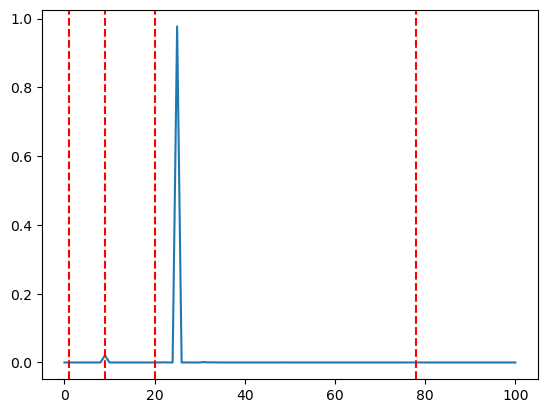

In [121]:
logits[0, -1].shape
plt.plot((logits[0, -1].softmax(-1)).detach().numpy())
plt.axvline(x=1, color='r', linestyle='--', label='Vertical Line 1')
plt.axvline(x=20, color='r', linestyle='--', label='Vertical Line 1')
plt.axvline(x=78, color='r', linestyle='--', label='Vertical Line 2')
plt.axvline(x=9, color='r', linestyle='--', label='Vertical Line 2')
plt.show()

In [117]:
torch.argmax(logits[0, -1])

tensor(25)

In [83]:
init_dict = torch.load('./sort5/init.pth')

/tmp/ipykernel_60018/2073116116.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  init_dict = torch.load('./sort5/init.pth')


In [84]:
tr = init_dict['train_data']
te = init_dict['test_data']
tr.shape

(20000, 11)

In [12]:
common_rows = torch.all(tr[:100][:, None] == te[:100], dim=2)
num_common_rows = torch.sum(torch.any(common_rows, dim=0))


TypeError: all() received an invalid combination of arguments - got (numpy.ndarray, dim=int), but expected one of:
 * (Tensor input, *, Tensor out = None)
 * (Tensor input, tuple of ints dim = None, bool keepdim = False, *, Tensor out = None)
 * (Tensor input, int dim, bool keepdim = False, *, Tensor out = None)
 * (Tensor input, name dim, bool keepdim = False, *, Tensor out = None)


In [ ]:
num_common_rows

In [42]:
tr_s = tr.sort(axis=-1)
te_s = te.sort(axis=-1)

cnt = 0
for i, x in enumerate(te):
    # print(x.shape, )
    if torch.tensor(tr == te[i]).all(dim=1).any():
        # print(x)
        cnt+=1

        print(x)
cnt

[ 0 18 23 78 91 91 91]
[  0  13  39  40  69 100 100]
[ 0 14 15 16 59 86 86]
[ 0 13 35 43 64 97 97]


4

In [36]:
cnt = 0
for i, x in enumerate(te):
    # print(x.shape, )
    if torch.tensor(tr == te[i]).all(dim=1).any():
        # print(x)
        cnt+=1
        print(cnt)
cnt

0

tensor(False)

In [91]:
np.unique(tr[:, 10].flatten(), return_counts=True)

(array([  9,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
         30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
         43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
         69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
         95,  96,  97,  98,  99, 100]),
 array([  1,   1,   1,   1,   3,   1,   3,   1,   2,   4,  10,   4,   7,
          4,   8,   6,  13,  18,   6,   9,  12,  20,  25,  21,  26,  22,
         34,  24,  32,  41,  52,  56,  62,  55,  66,  70,  79,  78,  89,
        102,  96, 106, 139, 108, 136, 145, 145, 163, 186, 192, 202, 221,
        240, 225, 250, 247, 269, 283, 303, 346, 332, 358, 390, 377, 404,
        431, 441, 453, 515, 509, 551, 638, 585, 664, 654, 711, 746, 817,
        842, 837, 836, 901, 975, 962]))

In [14]:
np.unique(tr[:,:-1].flatten(), return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100]),
 array([20000,   983,  1032,  1018,   997,  1003,  1084,  1044,   962,
         1004,  1012,   996,   991,  1013,   986,  1011,  1020,  1018,
          965,   924,  1036,   953,   999,   986,   934,  1025,  1057,
         1056,   964,   964,  1021,   989,   994,   913,   977,   971,
         1000,  1042,  1033,   995,  1008,   977,   987,   982,  1010,
         1027,  1081,   956,  1003,  1011,   990,  1039,  1015,  1019,
   

In [15]:
for name, parma in model.named_parameters():
    print(name)

embed.W_E
pos_embed.W_pos
blocks.0.attn.W_K
blocks.0.attn.W_Q
blocks.0.attn.W_V
blocks.0.attn.W_O
blocks.0.mlp.W_in
blocks.0.mlp.b_in
blocks.0.mlp.W_out
blocks.0.mlp.b_out
unembed.W_U


In [70]:
posemb = state_dict['model']['pos_embed.W_pos']
torch.nn.functional.cosine_similarity(posemb[2], posemb[3], dim=-1)

tensor(0.7014, device='cuda:0')

In [16]:
state_dict['model']['embed.W_E'].norm(dim=-1) - init_dict['model']['embed.W_E'].norm(dim=-1)

tensor([ 0.1259,  0.2533,  0.0897,  0.0441,  0.1471,  0.1510,  0.0424,  0.1423,
         0.1608,  0.0490,  0.1179,  0.1008,  0.1049,  0.0392,  0.1429,  0.1048,
         0.0712,  0.1164,  0.1196,  0.1489,  0.1084,  0.0857,  0.0750,  0.0248,
         0.0666,  0.1847,  0.1384,  0.1600,  0.0889,  0.0506,  0.1518,  0.1631,
         0.0708,  0.1518,  0.0415,  0.0947,  0.0629,  0.1294,  0.0331,  0.0285,
         0.1084,  0.1484,  0.0865,  0.1551,  0.1805,  0.0916,  0.0895,  0.1082,
         0.1252,  0.0488,  0.0379,  0.0220,  0.1183,  0.1610,  0.1272,  0.0788,
         0.2069,  0.0876,  0.2081, -0.0110,  0.0467,  0.1589,  0.0831,  0.0567,
         0.0935,  0.0597,  0.1389,  0.0991,  0.0974,  0.1015,  0.1642,  0.0279,
         0.1283,  0.0854,  0.1110,  0.1279,  0.1414,  0.1395,  0.1015,  0.0367,
         0.1073,  0.0848,  0.0635,  0.1744,  0.0748,  0.1349,  0.0308,  0.1319,
         0.0593,  0.1497,  0.1194,  0.2095,  0.0658,  0.1432,  0.1131,  0.0313,
         0.1124,  0.0627,  0.1211,  0.15

In [ ]:
cache['blocks.0.hook_resid_pre']

torch.Size([1, 4, 128])